To run an unsupervised classification on satellite data using Python you need GDAL, Numpy and Sklearn. If you wish to see the data you will also need Matplotlib. Assuming you have the libraries installed, import them at the start.
<br>
<br>
Lets start with a single band image

Warning 1: ./subset_2_of_subset_1_of_S1A_IW_GRDH_1SDV_20240109T095534_20240109T095559_052028_06499B_56C7_Orb_TC_Cal_Spk.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10192, 12464)
(127033088, 1)


/home/siddharth/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


127033088
10192


/tmp/ipykernel_210471/427506840.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', np.max(X_cluster) + 1)


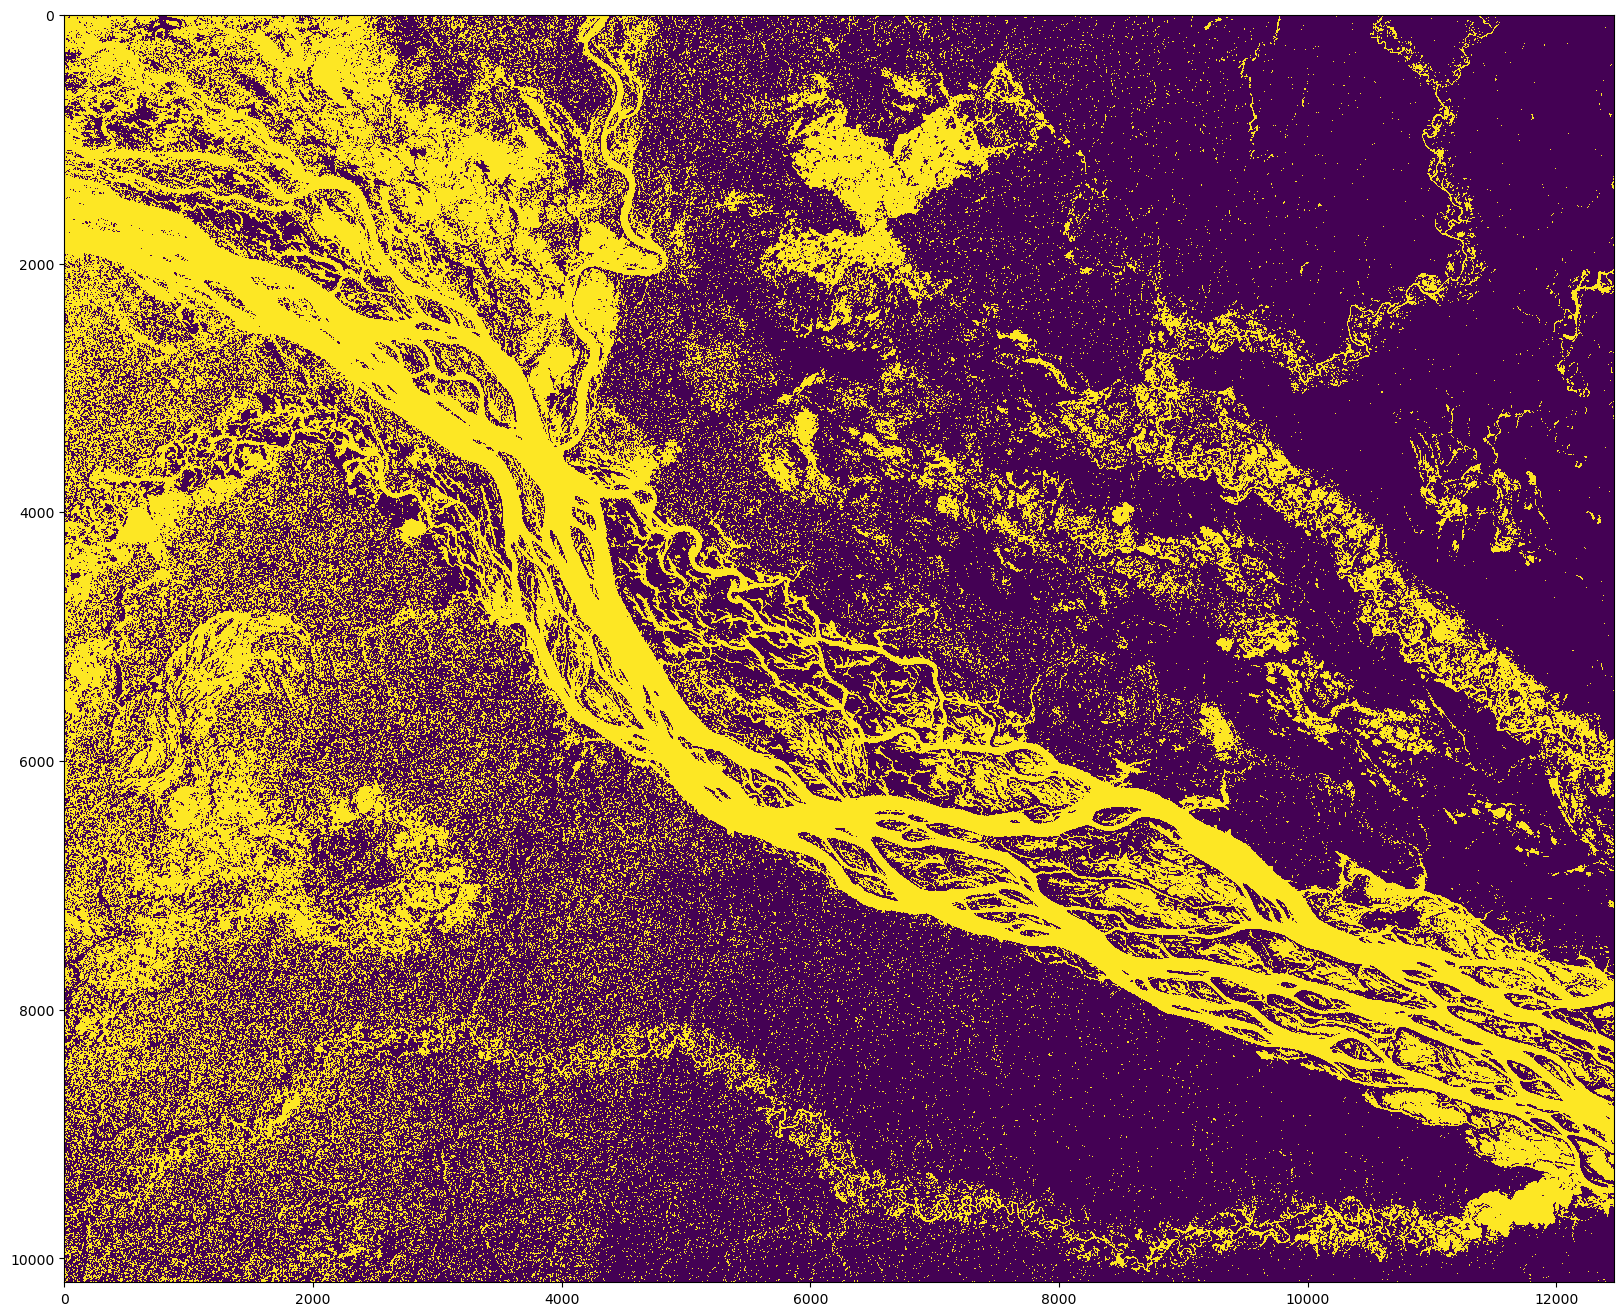

In [1]:
import numpy as np
from sklearn import cluster
from osgeo import gdal, gdal_array
import matplotlib.pyplot as plt
import gc
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()
# gdal.PushErrorHandler('CPLQuietErrorHandler')

# Read in raster image 
img_ds = gdal.Open("./subset_2_of_subset_1_of_S1A_IW_GRDH_1SDV_20240109T095534_20240109T095559_052028_06499B_56C7_Orb_TC_Cal_Spk.tif", gdal.GA_ReadOnly)

band = img_ds.GetRasterBand(2)

img = band.ReadAsArray()
print (img.shape)

X = img.reshape((-1,1))
print (X.shape)


k_means = cluster.KMeans(n_clusters=2, init="k-means++")
# print("here")
k_means.fit(X)
# print("Here1")

X_cluster = k_means.labels_
print(len(X_cluster))
X_cluster = X_cluster.reshape(img.shape)

print (len(X_cluster))

cmap = plt.cm.get_cmap('viridis', np.max(X_cluster) + 1)

plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap=cmap)

plt.show()

What about using all 13 bands of Sentinel 2?

In [2]:
del k_means, X, X_cluster, band, img
gc.collect()

3469

In [3]:
# Read in raster image 
img_ds = gdal.Open('./subset_2_of_subset_1_of_S1A_IW_GRDH_1SDV_20240109T095534_20240109T095559_052028_06499B_56C7_Orb_TC_Cal_Spk.tif', gdal.GA_ReadOnly)


img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount), gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
print (img.shape)

print (new_shape)


X = img[:, :, :13].reshape(new_shape)

print (X.shape)

Warning 1: ./subset_2_of_subset_1_of_S1A_IW_GRDH_1SDV_20240109T095534_20240109T095559_052028_06499B_56C7_Orb_TC_Cal_Spk.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10192, 12464, 2)
(127033088, 2)
(127033088, 2)


Now fit it

In [4]:
k_means = cluster.KMeans(n_clusters=2, init="k-means++")
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

/home/siddharth/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


And plot

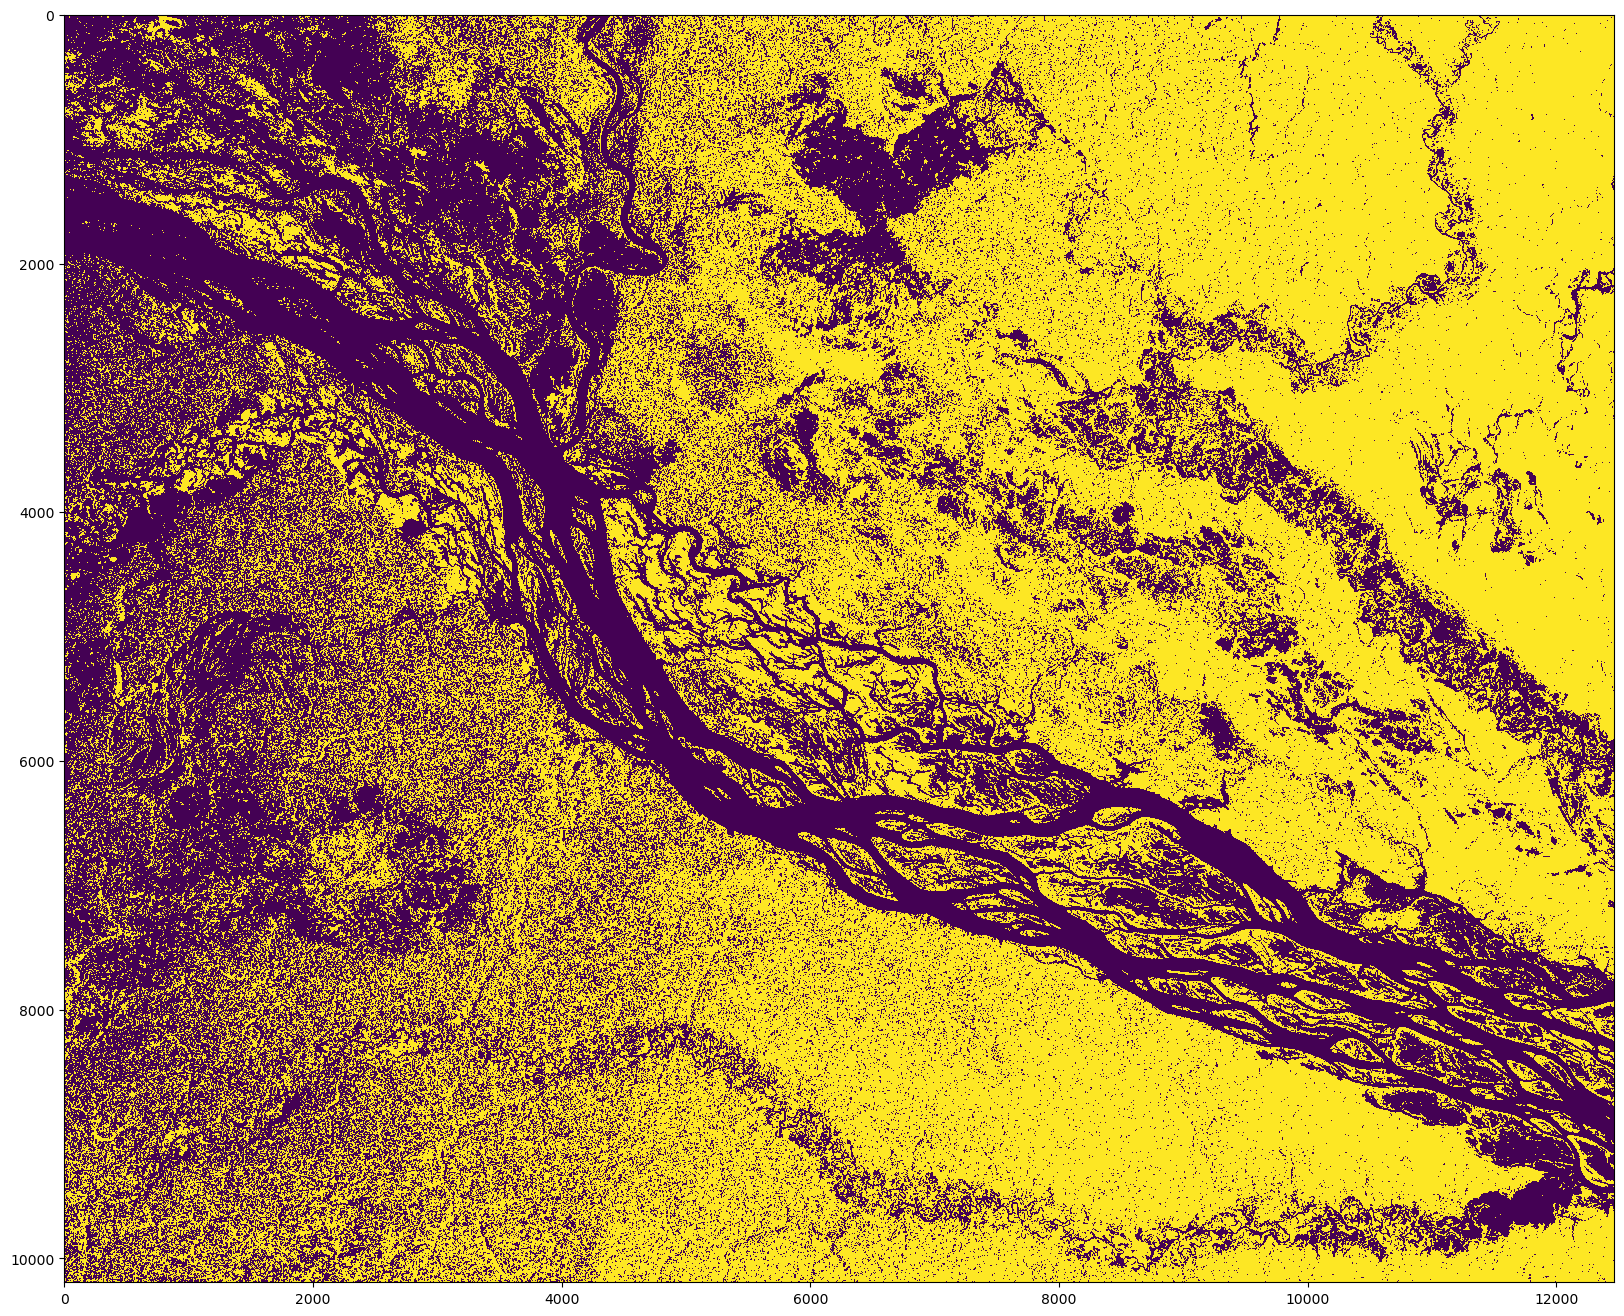

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster)
plt.show()

Changing the classification is straight forward. In this example choose MiniBatchKMeans

In [6]:
del k_means, X_cluster
gc.collect()

3494

In [14]:
MB_KMeans = cluster.MiniBatchKMeans(n_clusters=2, init="k-means++")
MB_KMeans.fit(X)

X_cluster = MB_KMeans.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

/home/siddharth/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Plot the result

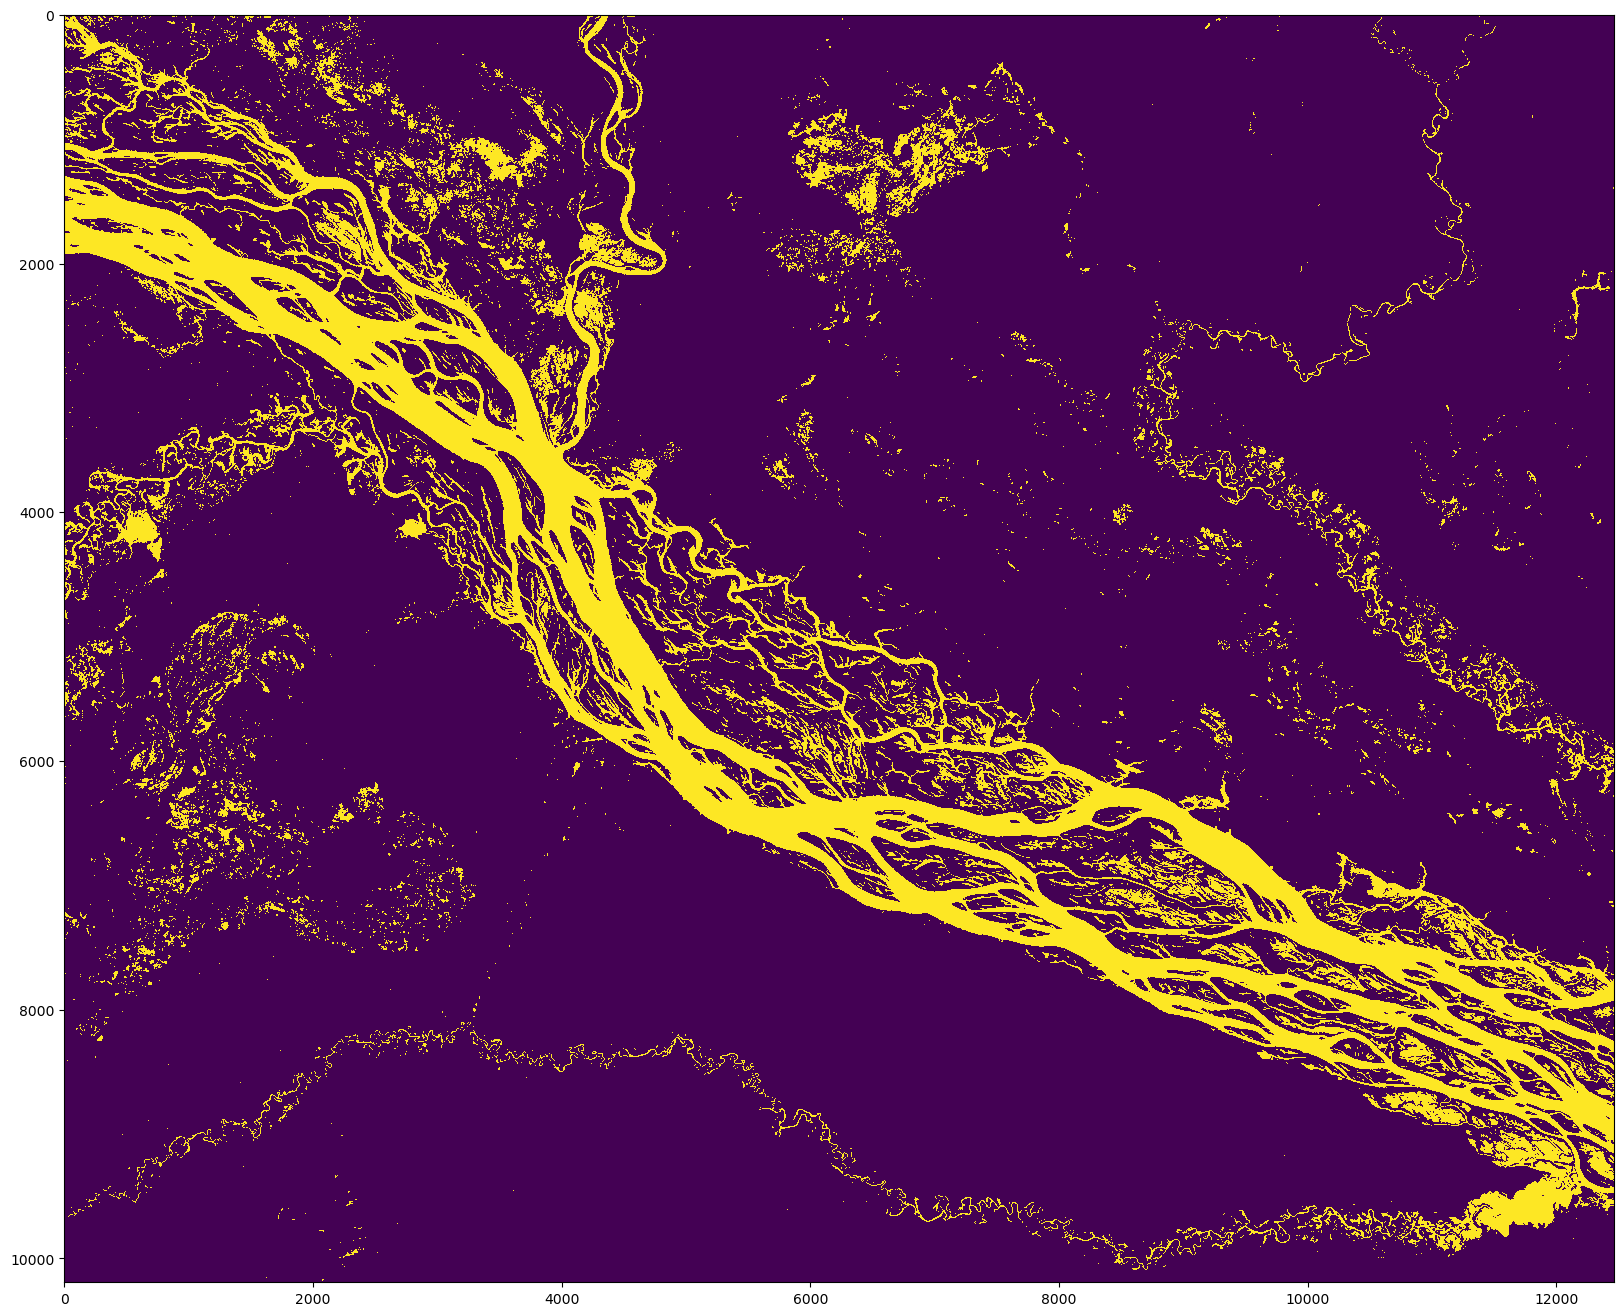

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap=cmap)

plt.show()

Final save the result to a new geotiff

In [10]:
ds = gdal.Open(".../S2_may_South_coast_clip.tif")
band = ds.GetRasterBand(2)
arr = band.ReadAsArray()
[cols, rows] = arr.shape

format = "GTiff"
driver = gdal.GetDriverByName(format)


outDataRaster = driver.Create(".../k_means.gtif", rows, cols, 1, gdal.GDT_Byte)
outDataRaster.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outDataRaster.SetProjection(ds.GetProjection())##sets same projection as input


outDataRaster.GetRasterBand(1).WriteArray(X_cluster)

outDataRaster.FlushCache() ## remove from memory
del outDataRaster ## delete the data (not the actual geotiff)

RuntimeError: .../S2_may_South_coast_clip.tif: No such file or directory